In [2]:
#library imports
import math
from collections import namedtuple
from fractions import Fraction 
from copy import copy
import numpy as np
from numpy.linalg import inv
from sympy import symbols
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
#some boilerplate code
Conditions = namedtuple('Conditions',('x0','xn','y0','yn','h','e'))

In [4]:
%%latex
\begin{align}
y'' -(y)^{2} -2 = 0\\
x \in (0,1) \\
y(0) = 0\\
y(1)= 0\\
\end{align}

<IPython.core.display.Latex object>

In [5]:
def initializer(x):
    return x*(1-x)

In [6]:
def Finite_Diff_Solver(cond, y_k, verbose=True):
    n = int(np.ceil((cond.xn - cond.x0)/cond.h))
    a, b, c, d = np.zeros((n-2)), np.zeros((n-1)), np.zeros((n-2)), np.zeros((n-1))
    #A
    b[0] = 2.0 * (-1.0/cond.h**2 + y_k[1])
    c[0] = 1.0/cond.h**2
    
    a[n-3] = 1.0/cond.h**2
    b[n-2] = 2.0 * (-1.0/cond.h**2 + y_k[-2])
    #d
    d[0] = 3 * y_k[1]**2 + 2
    d[n-2] = 3 * y_k[-2]**2 + 2
    for i, xi in enumerate(np.arange(cond.x0 + 2.0*cond.h, cond.xn - cond.h, cond.h),\
                           start=1):
        if (abs((cond.x0 + 2.0*cond.h) - (cond.xn - cond.h)) < 1e-7):
            continue
        a[i-1] = 1.0 / cond.h**2
        b[i] = 2.0 * (-1.0/cond.h**2 + y_k[i+1])
        c[i] = 1.0 / cond.h**2
        d[i] = 3 * y_k[i+1]**2 + 2
        
    def tridiag(a, b, c, k1=-1, k2=0, k3=1):
        return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
    if verbose:
        print("A={}".format(tridiag(a,b,c)))
        print("d={}".format(d.T))
        
    return(a,b,c,d)

In [7]:
def Thomas_Algorithm(coeff, cond):
    a, b, c, d = coeff
    n = int(np.ceil((cond.xn - cond.x0)/cond.h))
    c1 = np.zeros((n-2))
    d1 = np.zeros((n-1))
    c1[0] = c[0]/b[0]
    d1[0] = d[0]/b[0]
    for i in range(1,n-2):
        c1[i] = c[i]/(b[i]-a[i-1]*c1[i-1])
        d1[i] = (d[i] - a[i-1] * d1[i-1])/(b[i]-a[i-1]*c1[i-1])
    d1[n-2] = (d[n-2] - a[n-3] * d1[n-3])/(b[n-2] - a[n-3]*c1[n-3])
    def backsubstitution(c,d):
        y = np.zeros_like(d)
        y[-1] = d[-1]
        cache = y[-1]
        for i in reversed(range(d.shape[0]-1)):
            y[i] = d[i] - cache * c[i]
            cache = y[i]
        return y
    fin_y = backsubstitution(c1,d1)
    #print(fin_y)
    y = np.append(fin_y, cond.yn)
    y = np.append(cond.y0, y)
    return y

In [8]:
def Newton_Solver(cond):
    n = int(np.ceil((cond.xn - cond.x0)/cond.h))
    print(n)
    y_k = np.arange(cond.x0, cond.xn + cond.h, cond.h)
    #print(y_k)
    #print(initializer(y_k))
    solutions = []
    y_k = initializer(y_k)
    tuples_coeff = Finite_Diff_Solver(cond, y_k, verbose=False)
    y_k1 = Thomas_Algorithm(tuples_coeff, cond)
    s = np.max(abs(y_k1 - y_k))
    y_k = y_k1
    while(s > cond.e):
        y_k = copy(y_k1)
        solutions.append(y_k)
        tuples_coeff = Finite_Diff_Solver(cond, y_k, verbose=False)
        y_k1 = Thomas_Algorithm(tuples_coeff, cond)
        s = np.max(abs(y_k1 - y_k))
        #print(s)
        
    y_k = y_k1
    solutions.append(y_k)
    return solutions

In [10]:
cond = Conditions(0.0,1.0,0.0,0.0,Fraction(1,10),0.001)

10


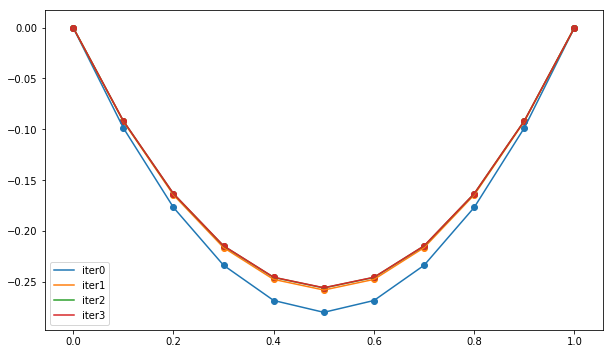

In [11]:
y = Newton_Solver(cond)
#print(len(y))
x_range = np.arange(cond.x0, cond.xn+cond.h, cond.h)
t1 = np.arange(cond.x0, cond.xn, 0.001)
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(311)
g = []
for i in range(len(y)):
    ax.plot(x_range, y[i])
    ax.scatter(x_range, y[i])
    g.append("iter"+str(i))
ax.legend(tuple(g))
fig.show()

5


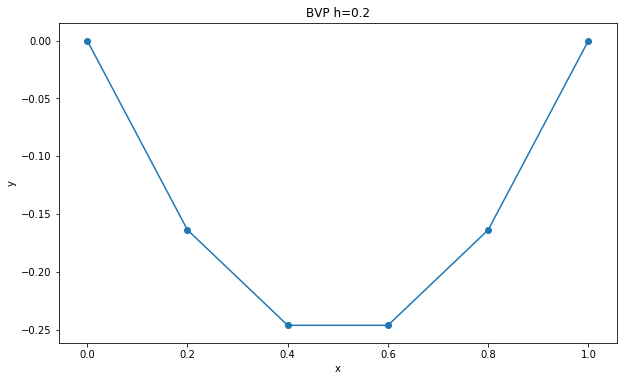

In [12]:
cond = Conditions(0.0,1.0,0.0,0.0,Fraction(1,5),0.001)
y = Newton_Solver(cond)
#print(len(y))
x_range = np.arange(cond.x0, cond.xn+cond.h, cond.h)
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(311)
ax.set(title="BVP h=0.2", xlabel="x", ylabel="y")
ax.plot(x_range, y[-1])
ax.scatter(x_range, y[-1])

fig.show()

10


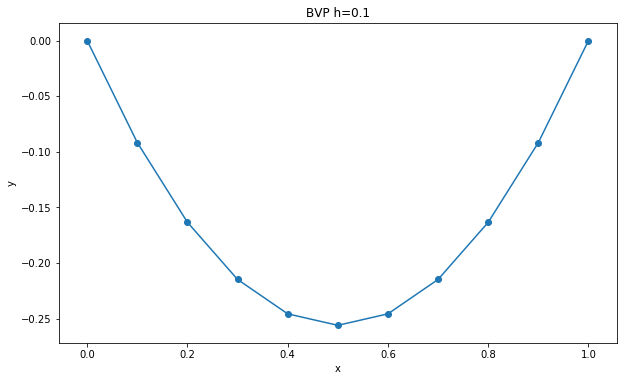

In [14]:
cond = Conditions(0.0,1.0,0.0,0.0,Fraction(1,10),0.001)
y = Newton_Solver(cond)
#print(len(y))
x_range = np.arange(cond.x0, cond.xn+cond.h, cond.h)
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(311)
ax.set(title="BVP h=0.1", xlabel="x", ylabel="y")
ax.plot(x_range, y[-1])
ax.scatter(x_range, y[-1])

fig.show()

100


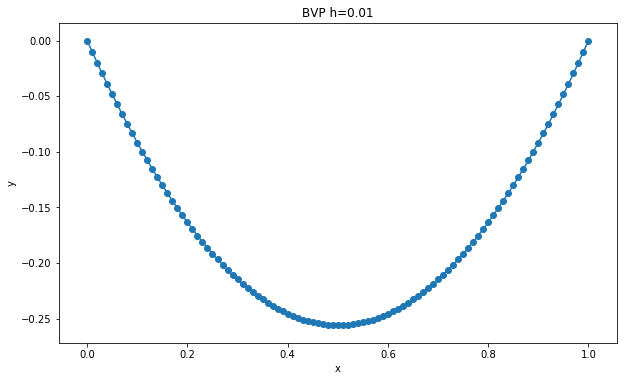

In [15]:
cond = Conditions(0.0,1.0,0.0,0.0,Fraction(1,100),0.001)
y = Newton_Solver(cond)
#print(len(y))
x_range = np.arange(cond.x0, cond.xn+cond.h, cond.h)
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(311)
ax.set(title="BVP h=0.01", xlabel="x", ylabel="y")
ax.plot(x_range, y[-1])
ax.scatter(x_range, y[-1])

fig.show()